In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML


from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

[main] Found existing base CSV: dfs training/GOOGL_base.csv


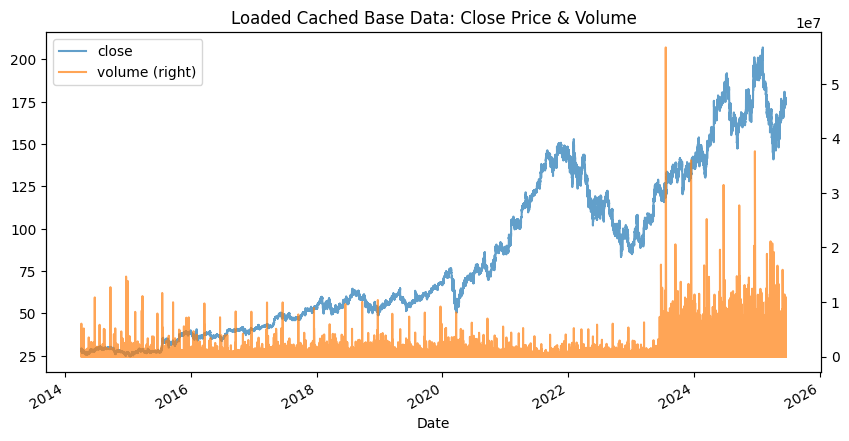

,open,high,low,close,volume,ask,bid
2014-04-03 11:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.617100,173.512900
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.432000,173.328000
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.362000,173.258000
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.332000,173.228000


In [3]:
ticker         = params.ticker
save_path      = params.save_path

results_folder = "optuna results"              
n_trials = 300
n_jobs = 1

base_csv = os.path.join(save_path, f"{ticker}_base.csv")

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back, 60))
    regular_start_shifted = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back*2, 60))

    # A) dynamic reference profit (median of all trade profits)
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract daily P&L values
    daily_returns = [
        stats['Strategy Return ($)'] 
        for _, (_, _, stats) in simulation.items()
    ]
    total_pnl = float(np.sum(daily_returns))

    # D) compute average daily P&L (zero‐trade days count as $0)
    trading_days   = df.index.normalize().unique()
    num_trading_days = len(trading_days)
    avg_daily_pnl = total_pnl / num_trading_days if num_trading_days else 0.0

    # E) report & cleanup
    print(f"→ Total P&L across {num_trading_days} days: ${total_pnl:.2f}")
    print(f"→ Average daily P&L             : ${avg_daily_pnl:.4f}\n")

    del simulation, daily_returns
    gc.collect()

    return avg_daily_pnl


In [5]:
def objective(trial):
    # 1) sample everything into a dict
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", [30,60,90,180]),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 1),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 1),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [1,2,3,5,10,15,45,60,90,120,180,240]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 0.75),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.05, 0.75),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.75),
    }

    # 2) Log the values for this trial
    print(f"\n▶ Trial {trial.number} Hyperparameters:")
    for name, val in hyperpars.items():
        print(f"    {name:30s} = {val}")
    print()

    # 3) Run the backtest & optimization function
    #    This will print Total P&L and Average Daily P&L,
    #    and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


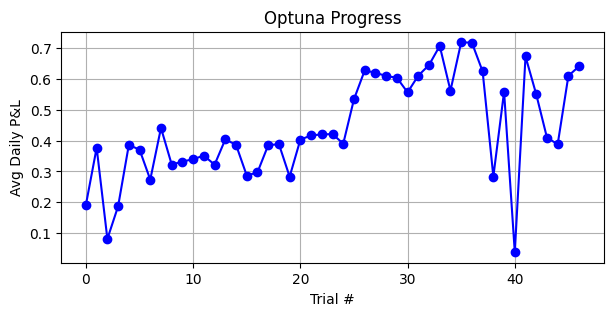

In [6]:

# small lists that hold only one int & float per trial
trial_x = []
trial_y = []

# build the blank figure once (same as before)
fig, ax = plt.subplots(figsize=(7, 3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Avg Daily P&L", title="Optuna Progress")
ax.grid(True)
handle = display(fig, display_id=True)
plt.close(fig)

def lightweight_plot_callback(study, trial):
    # Append just the new trial’s number & objective
    trial_x.append(trial.number)
    trial_y.append(trial.value)

    # Update the line data
    line.set_data(trial_x, trial_y)
    ax.relim()
    ax.autoscale_view()
    handle.update(fig)


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

def cleanup_cb(study, trial):
    import gc
    gc.collect()

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[cleanup_cb, lightweight_plot_callback],
    gc_after_trial=True,
)

fig, ax = plt.subplots(figsize=(8, 4))
plot_optimization_history(study, ax)
ax.set_title("Optuna Optimization History")
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")


[I 2025-07-24 17:53:24,779] A new study created in RDB with name: no-name-574600da-7b1a-4369-a236-ccda9d10f194



▶ Trial 0 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.7350870406305151
    max_down_prop                  = 0.8355879201858858
    gain_tightening_factor         = 0.4334381145482197
    merging_retracement_thr        = 0.6635712728467666
    merging_time_gap_thr           = 0.5711686265363666
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.4662773213237894
    short_penalty                  = 0.39242278420242194
    trailing_stop_thresh           = 0.7392953923726399
    buy_threshold                  = 0.35681405761507445

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 17:55:13,414] Trial 0 finished with value: 0.1922517730496454 and parameters: {'look_back': 180, 'min_prof_thr': 0.7350870406305151, 'max_down_prop': 0.8355879201858858, 'gain_tightening_factor': 0.4334381145482197, 'merging_retracement_thr': 0.6635712728467666, 'merging_time_gap_thr': 0.5711686265363666, 'smooth_win_sig': 180, 'pre_entry_decay': 0.4662773213237894, 'short_penalty': 0.39242278420242194, 'trailing_stop_thresh': 0.7392953923726399, 'buy_threshold': 0.35681405761507445}. Best is trial 0 with value: 0.1922517730496454.


→ Total P&L across 2820 days: $542.15
→ Average daily P&L             : $0.1923


▶ Trial 1 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.2422736649044527
    max_down_prop                  = 0.6476533068942034
    gain_tightening_factor         = 0.3923742135512085
    merging_retracement_thr        = 0.4846156335646785
    merging_time_gap_thr           = 0.9187726575007089
    smooth_win_sig                 = 3
    pre_entry_decay                = 0.18852841429878858
    short_penalty                  = 0.5717148383480031
    trailing_stop_thresh           = 0.46739644701391647
    buy_threshold                  = 0.46217131820990426

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 17:56:36,568] Trial 1 finished with value: 0.37679503546099286 and parameters: {'look_back': 60, 'min_prof_thr': 0.2422736649044527, 'max_down_prop': 0.6476533068942034, 'gain_tightening_factor': 0.3923742135512085, 'merging_retracement_thr': 0.4846156335646785, 'merging_time_gap_thr': 0.9187726575007089, 'smooth_win_sig': 3, 'pre_entry_decay': 0.18852841429878858, 'short_penalty': 0.5717148383480031, 'trailing_stop_thresh': 0.46739644701391647, 'buy_threshold': 0.46217131820990426}. Best is trial 1 with value: 0.37679503546099286.


→ Total P&L across 2820 days: $1062.56
→ Average daily P&L             : $0.3768


▶ Trial 2 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8215326961297362
    max_down_prop                  = 0.18270461141453717
    gain_tightening_factor         = 0.5448794343430973
    merging_retracement_thr        = 0.7996887707610338
    merging_time_gap_thr           = 0.40097962563649237
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.24677688003478868
    short_penalty                  = 0.07184975470389547
    trailing_stop_thresh           = 0.3004201704576448
    buy_threshold                  = 0.641973804928235

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 17:58:04,560] Trial 2 finished with value: 0.08114255319148936 and parameters: {'look_back': 90, 'min_prof_thr': 0.8215326961297362, 'max_down_prop': 0.18270461141453717, 'gain_tightening_factor': 0.5448794343430973, 'merging_retracement_thr': 0.7996887707610338, 'merging_time_gap_thr': 0.40097962563649237, 'smooth_win_sig': 240, 'pre_entry_decay': 0.24677688003478868, 'short_penalty': 0.07184975470389547, 'trailing_stop_thresh': 0.3004201704576448, 'buy_threshold': 0.641973804928235}. Best is trial 1 with value: 0.37679503546099286.


→ Total P&L across 2820 days: $228.82
→ Average daily P&L             : $0.0811


▶ Trial 3 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.5843628123643934
    max_down_prop                  = 0.33328465743584856
    gain_tightening_factor         = 0.6077233722629929
    merging_retracement_thr        = 0.1414855836768015
    merging_time_gap_thr           = 0.3861252736361428
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.036997981146653494
    short_penalty                  = 0.3641790857040412
    trailing_stop_thresh           = 0.16452884377115057
    buy_threshold                  = 0.4572658602138996

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 17:59:20,542] Trial 3 finished with value: 0.18684468085106384 and parameters: {'look_back': 30, 'min_prof_thr': 0.5843628123643934, 'max_down_prop': 0.33328465743584856, 'gain_tightening_factor': 0.6077233722629929, 'merging_retracement_thr': 0.1414855836768015, 'merging_time_gap_thr': 0.3861252736361428, 'smooth_win_sig': 240, 'pre_entry_decay': 0.036997981146653494, 'short_penalty': 0.3641790857040412, 'trailing_stop_thresh': 0.16452884377115057, 'buy_threshold': 0.4572658602138996}. Best is trial 1 with value: 0.37679503546099286.


→ Total P&L across 2820 days: $526.90
→ Average daily P&L             : $0.1868


▶ Trial 4 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.28584030696745344
    max_down_prop                  = 0.7515553498009958
    gain_tightening_factor         = 0.8123616623251202
    merging_retracement_thr        = 0.33668891843883814
    merging_time_gap_thr           = 0.8287034067400554
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.06478907115114305
    short_penalty                  = 0.5397173295974947
    trailing_stop_thresh           = 0.6602629675094421
    buy_threshold                  = 0.19092346646450814

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 18:01:30,705] Trial 4 finished with value: 0.38570283687943263 and parameters: {'look_back': 180, 'min_prof_thr': 0.28584030696745344, 'max_down_prop': 0.7515553498009958, 'gain_tightening_factor': 0.8123616623251202, 'merging_retracement_thr': 0.33668891843883814, 'merging_time_gap_thr': 0.8287034067400554, 'smooth_win_sig': 10, 'pre_entry_decay': 0.06478907115114305, 'short_penalty': 0.5397173295974947, 'trailing_stop_thresh': 0.6602629675094421, 'buy_threshold': 0.19092346646450814}. Best is trial 4 with value: 0.38570283687943263.


→ Total P&L across 2820 days: $1087.68
→ Average daily P&L             : $0.3857


▶ Trial 5 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.7327315741217217
    max_down_prop                  = 0.24844219754344074
    gain_tightening_factor         = 0.22374210706942874
    merging_retracement_thr        = 0.19339820572721794
    merging_time_gap_thr           = 0.15299369828551357
    smooth_win_sig                 = 5
    pre_entry_decay                = 0.3549353540751205
    short_penalty                  = 0.6689932690740482
    trailing_stop_thresh           = 0.7383000883165816
    buy_threshold                  = 0.14014363914167793

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1045.55
→ Average daily P&L             : $0.3708



[I 2025-07-24 18:03:06,258] Trial 5 finished with value: 0.3707631205673759 and parameters: {'look_back': 30, 'min_prof_thr': 0.7327315741217217, 'max_down_prop': 0.24844219754344074, 'gain_tightening_factor': 0.22374210706942874, 'merging_retracement_thr': 0.19339820572721794, 'merging_time_gap_thr': 0.15299369828551357, 'smooth_win_sig': 5, 'pre_entry_decay': 0.3549353540751205, 'short_penalty': 0.6689932690740482, 'trailing_stop_thresh': 0.7383000883165816, 'buy_threshold': 0.14014363914167793}. Best is trial 4 with value: 0.38570283687943263.



▶ Trial 6 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.48373837185506574
    max_down_prop                  = 0.303124686662917
    gain_tightening_factor         = 0.4306044592315853
    merging_retracement_thr        = 0.7139980985764417
    merging_time_gap_thr           = 0.6008709730841052
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.34049134081394505
    short_penalty                  = 0.356629007720508
    trailing_stop_thresh           = 0.36612464082252216
    buy_threshold                  = 0.3288009247749327

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $770.81
→ Average daily P&L             : $0.2733



[I 2025-07-24 18:04:41,318] Trial 6 finished with value: 0.27333652482269505 and parameters: {'look_back': 30, 'min_prof_thr': 0.48373837185506574, 'max_down_prop': 0.303124686662917, 'gain_tightening_factor': 0.4306044592315853, 'merging_retracement_thr': 0.7139980985764417, 'merging_time_gap_thr': 0.6008709730841052, 'smooth_win_sig': 180, 'pre_entry_decay': 0.34049134081394505, 'short_penalty': 0.356629007720508, 'trailing_stop_thresh': 0.36612464082252216, 'buy_threshold': 0.3288009247749327}. Best is trial 4 with value: 0.38570283687943263.



▶ Trial 7 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.2309902721522422
    max_down_prop                  = 0.3591322744775213
    gain_tightening_factor         = 0.6978342794919744
    merging_retracement_thr        = 0.353986336759053
    merging_time_gap_thr           = 0.777532998132855
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.3124184549340311
    short_penalty                  = 0.3256131764301516
    trailing_stop_thresh           = 0.15271976555566766
    buy_threshold                  = 0.23241607682560278

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1243.65
→ Average daily P&L             : $0.4410



[I 2025-07-24 18:06:54,628] Trial 7 finished with value: 0.44101099290780144 and parameters: {'look_back': 180, 'min_prof_thr': 0.2309902721522422, 'max_down_prop': 0.3591322744775213, 'gain_tightening_factor': 0.6978342794919744, 'merging_retracement_thr': 0.353986336759053, 'merging_time_gap_thr': 0.777532998132855, 'smooth_win_sig': 45, 'pre_entry_decay': 0.3124184549340311, 'short_penalty': 0.3256131764301516, 'trailing_stop_thresh': 0.15271976555566766, 'buy_threshold': 0.23241607682560278}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 8 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.4283807037933107
    max_down_prop                  = 0.3007542714345012
    gain_tightening_factor         = 0.5795366880543963
    merging_retracement_thr        = 0.6028638200043208
    merging_time_gap_thr           = 0.8888765949502849
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.34507789318935145
    short_penalty                  = 0.09091432333919772
    trailing_stop_thresh           = 0.13917744433392695
    buy_threshold                  = 0.23815827010209362

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $908.87
→ Average daily P&L             : $0.3223



[I 2025-07-24 18:09:10,014] Trial 8 finished with value: 0.32229290780141845 and parameters: {'look_back': 180, 'min_prof_thr': 0.4283807037933107, 'max_down_prop': 0.3007542714345012, 'gain_tightening_factor': 0.5795366880543963, 'merging_retracement_thr': 0.6028638200043208, 'merging_time_gap_thr': 0.8888765949502849, 'smooth_win_sig': 180, 'pre_entry_decay': 0.34507789318935145, 'short_penalty': 0.09091432333919772, 'trailing_stop_thresh': 0.13917744433392695, 'buy_threshold': 0.23815827010209362}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 9 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.7810950147577146
    max_down_prop                  = 0.33693009303840704
    gain_tightening_factor         = 0.27709838895117134
    merging_retracement_thr        = 0.8196873269359561
    merging_time_gap_thr           = 0.9253628841874764
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.4979182922542169
    short_penalty                  = 0.08816583284817706
    trailing_stop_thresh           = 0.2758994502348193
    buy_threshold                  = 0.19448592845281476

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $936.14
→ Average daily P&L             : $0.3320



[I 2025-07-24 18:10:52,782] Trial 9 finished with value: 0.33196489361702125 and parameters: {'look_back': 60, 'min_prof_thr': 0.7810950147577146, 'max_down_prop': 0.33693009303840704, 'gain_tightening_factor': 0.27709838895117134, 'merging_retracement_thr': 0.8196873269359561, 'merging_time_gap_thr': 0.9253628841874764, 'smooth_win_sig': 120, 'pre_entry_decay': 0.4979182922542169, 'short_penalty': 0.08816583284817706, 'trailing_stop_thresh': 0.2758994502348193, 'buy_threshold': 0.19448592845281476}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 10 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.11779865808196516
    max_down_prop                  = 0.5147434306659217
    gain_tightening_factor         = 0.9876637006207327
    merging_retracement_thr        = 0.381929876847793
    merging_time_gap_thr           = 0.7389829300283797
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.15252048431099138
    short_penalty                  = 0.22400385162117115
    trailing_stop_thresh           = 0.08112900299462597
    buy_threshold                  = 0.06489030996226408

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $957.85
→ Average daily P&L             : $0.3397



[I 2025-07-24 18:12:42,451] Trial 10 finished with value: 0.33966418439716317 and parameters: {'look_back': 90, 'min_prof_thr': 0.11779865808196516, 'max_down_prop': 0.5147434306659217, 'gain_tightening_factor': 0.9876637006207327, 'merging_retracement_thr': 0.381929876847793, 'merging_time_gap_thr': 0.7389829300283797, 'smooth_win_sig': 45, 'pre_entry_decay': 0.15252048431099138, 'short_penalty': 0.22400385162117115, 'trailing_stop_thresh': 0.08112900299462597, 'buy_threshold': 0.06489030996226408}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 11 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.3189261581910337
    max_down_prop                  = 0.8908759870728615
    gain_tightening_factor         = 0.8347582386152561
    merging_retracement_thr        = 0.3433689337504789
    merging_time_gap_thr           = 0.7454317166962824
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.027548271921002843
    short_penalty                  = 0.529254534091403
    trailing_stop_thresh           = 0.5514639223249109
    buy_threshold                  = 0.2575357744124038

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $990.70
→ Average daily P&L             : $0.3513



[I 2025-07-24 18:14:59,521] Trial 11 finished with value: 0.35131170212765955 and parameters: {'look_back': 180, 'min_prof_thr': 0.3189261581910337, 'max_down_prop': 0.8908759870728615, 'gain_tightening_factor': 0.8347582386152561, 'merging_retracement_thr': 0.3433689337504789, 'merging_time_gap_thr': 0.7454317166962824, 'smooth_win_sig': 45, 'pre_entry_decay': 0.027548271921002843, 'short_penalty': 0.529254534091403, 'trailing_stop_thresh': 0.5514639223249109, 'buy_threshold': 0.2575357744124038}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 12 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.1769835596659369
    max_down_prop                  = 0.671819540591673
    gain_tightening_factor         = 0.7849261725089954
    merging_retracement_thr        = 0.2856836307623786
    merging_time_gap_thr           = 0.7613548240873443
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.1252266097023791
    short_penalty                  = 0.5148274904390885
    trailing_stop_thresh           = 0.5913850933042638
    buy_threshold                  = 0.05714326085896332

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $907.46
→ Average daily P&L             : $0.3218



[I 2025-07-24 18:17:14,266] Trial 12 finished with value: 0.3217939716312057 and parameters: {'look_back': 180, 'min_prof_thr': 0.1769835596659369, 'max_down_prop': 0.671819540591673, 'gain_tightening_factor': 0.7849261725089954, 'merging_retracement_thr': 0.2856836307623786, 'merging_time_gap_thr': 0.7613548240873443, 'smooth_win_sig': 10, 'pre_entry_decay': 0.1252266097023791, 'short_penalty': 0.5148274904390885, 'trailing_stop_thresh': 0.5913850933042638, 'buy_threshold': 0.05714326085896332}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 13 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.3450928394103326
    max_down_prop                  = 0.48415287158544174
    gain_tightening_factor         = 0.7609963472789141
    merging_retracement_thr        = 0.5077495844462586
    merging_time_gap_thr           = 0.9932124915957203
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.25681422617623584
    short_penalty                  = 0.2523279264371485
    trailing_stop_thresh           = 0.5736435228750723
    buy_threshold                  = 0.30434679934584247

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1139.09
→ Average daily P&L             : $0.4039



[I 2025-07-24 18:19:31,995] Trial 13 finished with value: 0.4039308510638298 and parameters: {'look_back': 180, 'min_prof_thr': 0.3450928394103326, 'max_down_prop': 0.48415287158544174, 'gain_tightening_factor': 0.7609963472789141, 'merging_retracement_thr': 0.5077495844462586, 'merging_time_gap_thr': 0.9932124915957203, 'smooth_win_sig': 10, 'pre_entry_decay': 0.25681422617623584, 'short_penalty': 0.2523279264371485, 'trailing_stop_thresh': 0.5736435228750723, 'buy_threshold': 0.30434679934584247}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 14 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.38464424215652826
    max_down_prop                  = 0.47125103307013594
    gain_tightening_factor         = 0.7247909770124253
    merging_retracement_thr        = 0.48174818194973856
    merging_time_gap_thr           = 0.9811620237118718
    smooth_win_sig                 = 2
    pre_entry_decay                = 0.2888338733467157
    short_penalty                  = 0.23732098582352515
    trailing_stop_thresh           = 0.43943005932146995
    buy_threshold                  = 0.5337426185448872

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1088.97
→ Average daily P&L             : $0.3862



[I 2025-07-24 18:21:46,305] Trial 14 finished with value: 0.38616099290780137 and parameters: {'look_back': 180, 'min_prof_thr': 0.38464424215652826, 'max_down_prop': 0.47125103307013594, 'gain_tightening_factor': 0.7247909770124253, 'merging_retracement_thr': 0.48174818194973856, 'merging_time_gap_thr': 0.9811620237118718, 'smooth_win_sig': 2, 'pre_entry_decay': 0.2888338733467157, 'short_penalty': 0.23732098582352515, 'trailing_stop_thresh': 0.43943005932146995, 'buy_threshold': 0.5337426185448872}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 15 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.5833056084871613
    max_down_prop                  = 0.46363580122951564
    gain_tightening_factor         = 0.9447524880184497
    merging_retracement_thr        = 0.9984271890843224
    merging_time_gap_thr           = 0.6455073924584598
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.41342306360415837
    short_penalty                  = 0.2462397499370305
    trailing_stop_thresh           = 0.5257552218922965
    buy_threshold                  = 0.3385087060634718

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $808.25
→ Average daily P&L             : $0.2866



[I 2025-07-24 18:23:58,927] Trial 15 finished with value: 0.28661276595744684 and parameters: {'look_back': 180, 'min_prof_thr': 0.5833056084871613, 'max_down_prop': 0.46363580122951564, 'gain_tightening_factor': 0.9447524880184497, 'merging_retracement_thr': 0.9984271890843224, 'merging_time_gap_thr': 0.6455073924584598, 'smooth_win_sig': 90, 'pre_entry_decay': 0.41342306360415837, 'short_penalty': 0.2462397499370305, 'trailing_stop_thresh': 0.5257552218922965, 'buy_threshold': 0.3385087060634718}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 16 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.11226043522135065
    max_down_prop                  = 0.42998636241143234
    gain_tightening_factor         = 0.10399735112974051
    merging_retracement_thr        = 0.46671157775932615
    merging_time_gap_thr           = 0.987829075901467
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.2445250083059592
    short_penalty                  = 0.27511920935603174
    trailing_stop_thresh           = 0.23402053815918106
    buy_threshold                  = 0.6874179831343548

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $837.68
→ Average daily P&L             : $0.2970



[I 2025-07-24 18:26:13,241] Trial 16 finished with value: 0.2970485815602837 and parameters: {'look_back': 180, 'min_prof_thr': 0.11226043522135065, 'max_down_prop': 0.42998636241143234, 'gain_tightening_factor': 0.10399735112974051, 'merging_retracement_thr': 0.46671157775932615, 'merging_time_gap_thr': 0.987829075901467, 'smooth_win_sig': 60, 'pre_entry_decay': 0.2445250083059592, 'short_penalty': 0.27511920935603174, 'trailing_stop_thresh': 0.23402053815918106, 'buy_threshold': 0.6874179831343548}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 17 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.9499648790594419
    max_down_prop                  = 0.11074127018375995
    gain_tightening_factor         = 0.6634237379056809
    merging_retracement_thr        = 0.23029337328609195
    merging_time_gap_thr           = 0.4722747980387647
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.27135102809164724
    short_penalty                  = 0.16535853065972958
    trailing_stop_thresh           = 0.37412733425237293
    buy_threshold                  = 0.2725695258774565

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1085.95
→ Average daily P&L             : $0.3851



[I 2025-07-24 18:27:57,626] Trial 17 finished with value: 0.3850875886524823 and parameters: {'look_back': 60, 'min_prof_thr': 0.9499648790594419, 'max_down_prop': 0.11074127018375995, 'gain_tightening_factor': 0.6634237379056809, 'merging_retracement_thr': 0.23029337328609195, 'merging_time_gap_thr': 0.4722747980387647, 'smooth_win_sig': 15, 'pre_entry_decay': 0.27135102809164724, 'short_penalty': 0.16535853065972958, 'trailing_stop_thresh': 0.37412733425237293, 'buy_threshold': 0.2725695258774565}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 18 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.35013533325259216
    max_down_prop                  = 0.5650872267541917
    gain_tightening_factor         = 0.8845866280828938
    merging_retracement_thr        = 0.5620338019509483
    merging_time_gap_thr           = 0.8259230545584203
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.1935318832692265
    short_penalty                  = 0.44598503692838354
    trailing_stop_thresh           = 0.6251619539078449
    buy_threshold                  = 0.42041051368560567

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1095.16
→ Average daily P&L             : $0.3884



[I 2025-07-24 18:29:51,299] Trial 18 finished with value: 0.3883553191489362 and parameters: {'look_back': 90, 'min_prof_thr': 0.35013533325259216, 'max_down_prop': 0.5650872267541917, 'gain_tightening_factor': 0.8845866280828938, 'merging_retracement_thr': 0.5620338019509483, 'merging_time_gap_thr': 0.8259230545584203, 'smooth_win_sig': 1, 'pre_entry_decay': 0.1935318832692265, 'short_penalty': 0.44598503692838354, 'trailing_stop_thresh': 0.6251619539078449, 'buy_threshold': 0.42041051368560567}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 19 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.22372888724465617
    max_down_prop                  = 0.406310023624614
    gain_tightening_factor         = 0.7246904673168885
    merging_retracement_thr        = 0.414434967573296
    merging_time_gap_thr           = 0.11088588986344611
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.3150182123386438
    short_penalty                  = 0.32890470018552515
    trailing_stop_thresh           = 0.07023778354194077
    buy_threshold                  = 0.5536098335493468

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $797.75
→ Average daily P&L             : $0.2829



[I 2025-07-24 18:32:06,976] Trial 19 finished with value: 0.2828886524822695 and parameters: {'look_back': 180, 'min_prof_thr': 0.22372888724465617, 'max_down_prop': 0.406310023624614, 'gain_tightening_factor': 0.7246904673168885, 'merging_retracement_thr': 0.414434967573296, 'merging_time_gap_thr': 0.11088588986344611, 'smooth_win_sig': 45, 'pre_entry_decay': 0.3150182123386438, 'short_penalty': 0.32890470018552515, 'trailing_stop_thresh': 0.07023778354194077, 'buy_threshold': 0.5536098335493468}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 20 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.48455611878606686
    max_down_prop                  = 0.5763128593896234
    gain_tightening_factor         = 0.5076524767485076
    merging_retracement_thr        = 0.12563980988631573
    merging_time_gap_thr           = 0.6797395350240472
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.4023277328519728
    short_penalty                  = 0.7470534890623267
    trailing_stop_thresh           = 0.45921600633728094
    buy_threshold                  = 0.12920203680939857

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1136.32
→ Average daily P&L             : $0.4030



[I 2025-07-24 18:34:23,458] Trial 20 finished with value: 0.40295070921985815 and parameters: {'look_back': 180, 'min_prof_thr': 0.48455611878606686, 'max_down_prop': 0.5763128593896234, 'gain_tightening_factor': 0.5076524767485076, 'merging_retracement_thr': 0.12563980988631573, 'merging_time_gap_thr': 0.6797395350240472, 'smooth_win_sig': 10, 'pre_entry_decay': 0.4023277328519728, 'short_penalty': 0.7470534890623267, 'trailing_stop_thresh': 0.45921600633728094, 'buy_threshold': 0.12920203680939857}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 21 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.5010211236461286
    max_down_prop                  = 0.5850163665530634
    gain_tightening_factor         = 0.4906270030249371
    merging_retracement_thr        = 0.12051373873997882
    merging_time_gap_thr           = 0.6901456285143217
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.4014015282233957
    short_penalty                  = 0.6405038529620225
    trailing_stop_thresh           = 0.5021545592793568
    buy_threshold                  = 0.12793121054615567

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1175.41
→ Average daily P&L             : $0.4168



[I 2025-07-24 18:36:41,498] Trial 21 finished with value: 0.4168117021276596 and parameters: {'look_back': 180, 'min_prof_thr': 0.5010211236461286, 'max_down_prop': 0.5850163665530634, 'gain_tightening_factor': 0.4906270030249371, 'merging_retracement_thr': 0.12051373873997882, 'merging_time_gap_thr': 0.6901456285143217, 'smooth_win_sig': 10, 'pre_entry_decay': 0.4014015282233957, 'short_penalty': 0.6405038529620225, 'trailing_stop_thresh': 0.5021545592793568, 'buy_threshold': 0.12793121054615567}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 22 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.4952211477077948
    max_down_prop                  = 0.6027322340552723
    gain_tightening_factor         = 0.6630904512219572
    merging_retracement_thr        = 0.257655217942713
    merging_time_gap_thr           = 0.8341584010844125
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.40943339102328574
    short_penalty                  = 0.45540841858257974
    trailing_stop_thresh           = 0.5215384533442342
    buy_threshold                  = 0.13743680003166917

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1184.12
→ Average daily P&L             : $0.4199



[I 2025-07-24 18:38:55,291] Trial 22 finished with value: 0.41990248226950355 and parameters: {'look_back': 180, 'min_prof_thr': 0.4952211477077948, 'max_down_prop': 0.6027322340552723, 'gain_tightening_factor': 0.6630904512219572, 'merging_retracement_thr': 0.257655217942713, 'merging_time_gap_thr': 0.8341584010844125, 'smooth_win_sig': 10, 'pre_entry_decay': 0.40943339102328574, 'short_penalty': 0.45540841858257974, 'trailing_stop_thresh': 0.5215384533442342, 'buy_threshold': 0.13743680003166917}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 23 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.6502782297876653
    max_down_prop                  = 0.6590405712499758
    gain_tightening_factor         = 0.6699634774390255
    merging_retracement_thr        = 0.26337423331570575
    merging_time_gap_thr           = 0.836142823123346
    smooth_win_sig                 = 10
    pre_entry_decay                = 0.4089600788419552
    short_penalty                  = 0.4593532856067576
    trailing_stop_thresh           = 0.4992735002050698
    buy_threshold                  = 0.14171945238484845

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1187.38
→ Average daily P&L             : $0.4211



[I 2025-07-24 18:41:10,228] Trial 23 finished with value: 0.42105780141843974 and parameters: {'look_back': 180, 'min_prof_thr': 0.6502782297876653, 'max_down_prop': 0.6590405712499758, 'gain_tightening_factor': 0.6699634774390255, 'merging_retracement_thr': 0.26337423331570575, 'merging_time_gap_thr': 0.836142823123346, 'smooth_win_sig': 10, 'pre_entry_decay': 0.4089600788419552, 'short_penalty': 0.4593532856067576, 'trailing_stop_thresh': 0.4992735002050698, 'buy_threshold': 0.14171945238484845}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 24 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.6459357877035381
    max_down_prop                  = 0.7199139273446964
    gain_tightening_factor         = 0.6277035517940487
    merging_retracement_thr        = 0.25495222138258933
    merging_time_gap_thr           = 0.827057596546264
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.44273535298450617
    short_penalty                  = 0.4663185061043197
    trailing_stop_thresh           = 0.40298963808658295
    buy_threshold                  = 0.19999501142595152

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1099.59
→ Average daily P&L             : $0.3899



[I 2025-07-24 18:43:24,862] Trial 24 finished with value: 0.38992695035460995 and parameters: {'look_back': 180, 'min_prof_thr': 0.6459357877035381, 'max_down_prop': 0.7199139273446964, 'gain_tightening_factor': 0.6277035517940487, 'merging_retracement_thr': 0.25495222138258933, 'merging_time_gap_thr': 0.827057596546264, 'smooth_win_sig': 15, 'pre_entry_decay': 0.44273535298450617, 'short_penalty': 0.4663185061043197, 'trailing_stop_thresh': 0.40298963808658295, 'buy_threshold': 0.19999501142595152}. Best is trial 7 with value: 0.44101099290780144.



▶ Trial 25 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.6791759286706782
    max_down_prop                  = 0.6617598285567536
    gain_tightening_factor         = 0.6803497112937202
    merging_retracement_thr        = 0.30778794112231456
    merging_time_gap_thr           = 0.49700856828558304
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.3732421891449013
    short_penalty                  = 0.44710153972372324
    trailing_stop_thresh           = 0.32471999969045334
    buy_threshold                  = 0.11080874795606237

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1505.90
→ Average daily P&L             : $0.5340



[I 2025-07-24 18:45:39,695] Trial 25 finished with value: 0.5340081560283688 and parameters: {'look_back': 180, 'min_prof_thr': 0.6791759286706782, 'max_down_prop': 0.6617598285567536, 'gain_tightening_factor': 0.6803497112937202, 'merging_retracement_thr': 0.30778794112231456, 'merging_time_gap_thr': 0.49700856828558304, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3732421891449013, 'short_penalty': 0.44710153972372324, 'trailing_stop_thresh': 0.32471999969045334, 'buy_threshold': 0.11080874795606237}. Best is trial 25 with value: 0.5340081560283688.



▶ Trial 26 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.6669246236063403
    max_down_prop                  = 0.7651527722872957
    gain_tightening_factor         = 0.712037382222125
    merging_retracement_thr        = 0.3195181698825657
    merging_time_gap_thr           = 0.4976950219947393
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.37305115081622
    short_penalty                  = 0.3218531258096007
    trailing_stop_thresh           = 0.1916416526790694
    buy_threshold                  = 0.09068731961677669

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1769.24
→ Average daily P&L             : $0.6274



[I 2025-07-24 18:47:34,018] Trial 26 finished with value: 0.627391134751773 and parameters: {'look_back': 90, 'min_prof_thr': 0.6669246236063403, 'max_down_prop': 0.7651527722872957, 'gain_tightening_factor': 0.712037382222125, 'merging_retracement_thr': 0.3195181698825657, 'merging_time_gap_thr': 0.4976950219947393, 'smooth_win_sig': 1, 'pre_entry_decay': 0.37305115081622, 'short_penalty': 0.3218531258096007, 'trailing_stop_thresh': 0.1916416526790694, 'buy_threshold': 0.09068731961677669}. Best is trial 26 with value: 0.627391134751773.



▶ Trial 27 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8897494104833434
    max_down_prop                  = 0.7774574073432471
    gain_tightening_factor         = 0.8855839578795656
    merging_retracement_thr        = 0.40390108203054265
    merging_time_gap_thr           = 0.48966164892991487
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.3201414769004587
    short_penalty                  = 0.31043728632436995
    trailing_stop_thresh           = 0.1911235466410622
    buy_threshold                  = 0.07748414266774177

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1748.63
→ Average daily P&L             : $0.6201



[I 2025-07-24 18:49:22,687] Trial 27 finished with value: 0.6200819148936171 and parameters: {'look_back': 90, 'min_prof_thr': 0.8897494104833434, 'max_down_prop': 0.7774574073432471, 'gain_tightening_factor': 0.8855839578795656, 'merging_retracement_thr': 0.40390108203054265, 'merging_time_gap_thr': 0.48966164892991487, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3201414769004587, 'short_penalty': 0.31043728632436995, 'trailing_stop_thresh': 0.1911235466410622, 'buy_threshold': 0.07748414266774177}. Best is trial 26 with value: 0.627391134751773.



▶ Trial 28 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.9933360485713761
    max_down_prop                  = 0.7906328334492905
    gain_tightening_factor         = 0.8911054767900694
    merging_retracement_thr        = 0.42319326058659357
    merging_time_gap_thr           = 0.2621055679513223
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.36913387933446573
    short_penalty                  = 0.1571388482246626
    trailing_stop_thresh           = 0.21123462176815166
    buy_threshold                  = 0.08648282824221358

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1718.44
→ Average daily P&L             : $0.6094



[I 2025-07-24 18:51:14,465] Trial 28 finished with value: 0.6093748226950354 and parameters: {'look_back': 90, 'min_prof_thr': 0.9933360485713761, 'max_down_prop': 0.7906328334492905, 'gain_tightening_factor': 0.8911054767900694, 'merging_retracement_thr': 0.42319326058659357, 'merging_time_gap_thr': 0.2621055679513223, 'smooth_win_sig': 1, 'pre_entry_decay': 0.36913387933446573, 'short_penalty': 0.1571388482246626, 'trailing_stop_thresh': 0.21123462176815166, 'buy_threshold': 0.08648282824221358}. Best is trial 26 with value: 0.627391134751773.



▶ Trial 29 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.9989508125488809
    max_down_prop                  = 0.8006046211654824
    gain_tightening_factor         = 0.9078542413609881
    merging_retracement_thr        = 0.6136969474686195
    merging_time_gap_thr           = 0.2477094633898835
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4655376717416294
    short_penalty                  = 0.16019889347731442
    trailing_stop_thresh           = 0.24352449133207418
    buy_threshold                  = 0.07759883662347886

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1702.84
→ Average daily P&L             : $0.6038



[I 2025-07-24 18:53:02,767] Trial 29 finished with value: 0.6038421985815603 and parameters: {'look_back': 90, 'min_prof_thr': 0.9989508125488809, 'max_down_prop': 0.8006046211654824, 'gain_tightening_factor': 0.9078542413609881, 'merging_retracement_thr': 0.6136969474686195, 'merging_time_gap_thr': 0.2477094633898835, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4655376717416294, 'short_penalty': 0.16019889347731442, 'trailing_stop_thresh': 0.24352449133207418, 'buy_threshold': 0.07759883662347886}. Best is trial 26 with value: 0.627391134751773.



▶ Trial 30 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8814320372166435
    max_down_prop                  = 0.8513618615081509
    gain_tightening_factor         = 0.8530751831040867
    merging_retracement_thr        = 0.5566817803525453
    merging_time_gap_thr           = 0.2873137546178762
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.31192107795936785
    short_penalty                  = 0.1767451695087235
    trailing_stop_thresh           = 0.20433473564031482
    buy_threshold                  = 0.1794786766585293

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-24 18:54:50,108] Trial 30 finished with value: 0.5564368794326241 and parameters: {'look_back': 90, 'min_prof_thr': 0.8814320372166435, 'max_down_prop': 0.8513618615081509, 'gain_tightening_factor': 0.8530751831040867, 'merging_retracement_thr': 0.5566817803525453, 'merging_time_gap_thr': 0.2873137546178762, 'smooth_win_sig': 1, 'pre_entry_decay': 0.31192107795936785, 'short_penalty': 0.1767451695087235, 'trailing_stop_thresh': 0.20433473564031482, 'buy_threshold': 0.1794786766585293}. Best is trial 26 with value: 0.627391134751773.


→ Total P&L across 2820 days: $1569.15
→ Average daily P&L             : $0.5564


▶ Trial 31 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.999614263103175
    max_down_prop                  = 0.782106106130233
    gain_tightening_factor         = 0.914772093976082
    merging_retracement_thr        = 0.644801320599469
    merging_time_gap_thr           = 0.23947301725555958
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4853841730901264
    short_penalty                  = 0.14746933088101985
    trailing_stop_thresh           = 0.23893689524081185
    buy_threshold                  = 0.07747776877298214

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1722.19
→ Average daily P&L             : $0.6107



[I 2025-07-24 18:56:42,530] Trial 31 finished with value: 0.6107070921985817 and parameters: {'look_back': 90, 'min_prof_thr': 0.999614263103175, 'max_down_prop': 0.782106106130233, 'gain_tightening_factor': 0.914772093976082, 'merging_retracement_thr': 0.644801320599469, 'merging_time_gap_thr': 0.23947301725555958, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4853841730901264, 'short_penalty': 0.14746933088101985, 'trailing_stop_thresh': 0.23893689524081185, 'buy_threshold': 0.07747776877298214}. Best is trial 26 with value: 0.627391134751773.



▶ Trial 32 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.9037703123551993
    max_down_prop                  = 0.7539361848694387
    gain_tightening_factor         = 0.9756587965467536
    merging_retracement_thr        = 0.4335777991835068
    merging_time_gap_thr           = 0.26742761149168254
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.495244631464861
    short_penalty                  = 0.12447969201073536
    trailing_stop_thresh           = 0.20608169604726287
    buy_threshold                  = 0.05486048469076496

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1819.07
→ Average daily P&L             : $0.6451



[I 2025-07-24 18:58:31,108] Trial 32 finished with value: 0.6450595744680852 and parameters: {'look_back': 90, 'min_prof_thr': 0.9037703123551993, 'max_down_prop': 0.7539361848694387, 'gain_tightening_factor': 0.9756587965467536, 'merging_retracement_thr': 0.4335777991835068, 'merging_time_gap_thr': 0.26742761149168254, 'smooth_win_sig': 1, 'pre_entry_decay': 0.495244631464861, 'short_penalty': 0.12447969201073536, 'trailing_stop_thresh': 0.20608169604726287, 'buy_threshold': 0.05486048469076496}. Best is trial 32 with value: 0.6450595744680852.



▶ Trial 33 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8889997346308656
    max_down_prop                  = 0.744415605437598
    gain_tightening_factor         = 0.9893382152227456
    merging_retracement_thr        = 0.7635100852090917
    merging_time_gap_thr           = 0.3619315431030189
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4994047281782821
    short_penalty                  = 0.12657322405665242
    trailing_stop_thresh           = 0.12646657481780277
    buy_threshold                  = 0.058519420309104044

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1993.44
→ Average daily P&L             : $0.7069



[I 2025-07-24 19:00:24,937] Trial 33 finished with value: 0.7068921985815604 and parameters: {'look_back': 90, 'min_prof_thr': 0.8889997346308656, 'max_down_prop': 0.744415605437598, 'gain_tightening_factor': 0.9893382152227456, 'merging_retracement_thr': 0.7635100852090917, 'merging_time_gap_thr': 0.3619315431030189, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4994047281782821, 'short_penalty': 0.12657322405665242, 'trailing_stop_thresh': 0.12646657481780277, 'buy_threshold': 0.058519420309104044}. Best is trial 33 with value: 0.7068921985815604.



▶ Trial 34 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8761688299443022
    max_down_prop                  = 0.7090260686938562
    gain_tightening_factor         = 0.9964447863912841
    merging_retracement_thr        = 0.7367709583331248
    merging_time_gap_thr           = 0.38592726912123115
    smooth_win_sig                 = 3
    pre_entry_decay                = 0.44380055980518784
    short_penalty                  = 0.11151376280711535
    trailing_stop_thresh           = 0.1090457206241709
    buy_threshold                  = 0.16229284607110311

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1584.84
→ Average daily P&L             : $0.5620



[I 2025-07-24 19:02:15,064] Trial 34 finished with value: 0.5619985815602837 and parameters: {'look_back': 90, 'min_prof_thr': 0.8761688299443022, 'max_down_prop': 0.7090260686938562, 'gain_tightening_factor': 0.9964447863912841, 'merging_retracement_thr': 0.7367709583331248, 'merging_time_gap_thr': 0.38592726912123115, 'smooth_win_sig': 3, 'pre_entry_decay': 0.44380055980518784, 'short_penalty': 0.11151376280711535, 'trailing_stop_thresh': 0.1090457206241709, 'buy_threshold': 0.16229284607110311}. Best is trial 33 with value: 0.7068921985815604.



▶ Trial 35 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.86638058022083
    max_down_prop                  = 0.8533291902554261
    gain_tightening_factor         = 0.9569570142894139
    merging_retracement_thr        = 0.9306150016912476
    merging_time_gap_thr           = 0.3205814191693752
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4553846710349618
    short_penalty                  = 0.05483406584158357
    trailing_stop_thresh           = 0.11600251778027733
    buy_threshold                  = 0.05022808302999376

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $2027.39
→ Average daily P&L             : $0.7189



[I 2025-07-24 19:04:08,285] Trial 35 finished with value: 0.7189340425531914 and parameters: {'look_back': 90, 'min_prof_thr': 0.86638058022083, 'max_down_prop': 0.8533291902554261, 'gain_tightening_factor': 0.9569570142894139, 'merging_retracement_thr': 0.9306150016912476, 'merging_time_gap_thr': 0.3205814191693752, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4553846710349618, 'short_penalty': 0.05483406584158357, 'trailing_stop_thresh': 0.11600251778027733, 'buy_threshold': 0.05022808302999376}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 36 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8042796997930881
    max_down_prop                  = 0.8536115127089475
    gain_tightening_factor         = 0.9667968624276763
    merging_retracement_thr        = 0.9319181941499125
    merging_time_gap_thr           = 0.3353965116777811
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4587186550521881
    short_penalty                  = 0.06717710820796507
    trailing_stop_thresh           = 0.11564307261087449
    buy_threshold                  = 0.05432951004184388

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $2022.78
→ Average daily P&L             : $0.7173



[I 2025-07-24 19:06:00,250] Trial 36 finished with value: 0.7172975177304963 and parameters: {'look_back': 90, 'min_prof_thr': 0.8042796997930881, 'max_down_prop': 0.8536115127089475, 'gain_tightening_factor': 0.9667968624276763, 'merging_retracement_thr': 0.9319181941499125, 'merging_time_gap_thr': 0.3353965116777811, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4587186550521881, 'short_penalty': 0.06717710820796507, 'trailing_stop_thresh': 0.11564307261087449, 'buy_threshold': 0.05432951004184388}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 37 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8142974406609332
    max_down_prop                  = 0.8916842476568804
    gain_tightening_factor         = 0.9481584203298594
    merging_retracement_thr        = 0.9342767154046443
    merging_time_gap_thr           = 0.32064587619524554
    smooth_win_sig                 = 5
    pre_entry_decay                = 0.4593290380027417
    short_penalty                  = 0.06665955569021577
    trailing_stop_thresh           = 0.0530566347336571
    buy_threshold                  = 0.05063963489366108

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1760.68
→ Average daily P&L             : $0.6244



[I 2025-07-24 19:07:52,856] Trial 37 finished with value: 0.6243556737588652 and parameters: {'look_back': 90, 'min_prof_thr': 0.8142974406609332, 'max_down_prop': 0.8916842476568804, 'gain_tightening_factor': 0.9481584203298594, 'merging_retracement_thr': 0.9342767154046443, 'merging_time_gap_thr': 0.32064587619524554, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4593290380027417, 'short_penalty': 0.06665955569021577, 'trailing_stop_thresh': 0.0530566347336571, 'buy_threshold': 0.05063963489366108}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 38 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.76333953452296
    max_down_prop                  = 0.8308734728517685
    gain_tightening_factor         = 0.9645419496453517
    merging_retracement_thr        = 0.8656855408099339
    merging_time_gap_thr           = 0.34331139528143007
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.4972472395504369
    short_penalty                  = 0.05149988401609609
    trailing_stop_thresh           = 0.11673400341743047
    buy_threshold                  = 0.11128217029567611

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $798.95
→ Average daily P&L             : $0.2833



[I 2025-07-24 19:09:45,486] Trial 38 finished with value: 0.2833148936170213 and parameters: {'look_back': 90, 'min_prof_thr': 0.76333953452296, 'max_down_prop': 0.8308734728517685, 'gain_tightening_factor': 0.9645419496453517, 'merging_retracement_thr': 0.8656855408099339, 'merging_time_gap_thr': 0.34331139528143007, 'smooth_win_sig': 240, 'pre_entry_decay': 0.4972472395504369, 'short_penalty': 0.05149988401609609, 'trailing_stop_thresh': 0.11673400341743047, 'buy_threshold': 0.11128217029567611}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 39 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.9345690875873028
    max_down_prop                  = 0.8451559535611969
    gain_tightening_factor         = 0.810768942839186
    merging_retracement_thr        = 0.8784310601541674
    merging_time_gap_thr           = 0.16184751771794054
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4398211765074742
    short_penalty                  = 0.13207063450380918
    trailing_stop_thresh           = 0.10767641672972346
    buy_threshold                  = 0.21699560451027625

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1574.33
→ Average daily P&L             : $0.5583



[I 2025-07-24 19:11:20,631] Trial 39 finished with value: 0.5582730496453902 and parameters: {'look_back': 30, 'min_prof_thr': 0.9345690875873028, 'max_down_prop': 0.8451559535611969, 'gain_tightening_factor': 0.810768942839186, 'merging_retracement_thr': 0.8784310601541674, 'merging_time_gap_thr': 0.16184751771794054, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4398211765074742, 'short_penalty': 0.13207063450380918, 'trailing_stop_thresh': 0.10767641672972346, 'buy_threshold': 0.21699560451027625}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 40 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8275822395380037
    max_down_prop                  = 0.7240919301648692
    gain_tightening_factor         = 0.9372832118528833
    merging_retracement_thr        = 0.7284802543528461
    merging_time_gap_thr           = 0.2044910582495855
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.47349878769205545
    short_penalty                  = 0.1937170372807627
    trailing_stop_thresh           = 0.15823744291259512
    buy_threshold                  = 0.7411874544607393

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $107.13
→ Average daily P&L             : $0.0380



[I 2025-07-24 19:13:10,010] Trial 40 finished with value: 0.03798900709219858 and parameters: {'look_back': 90, 'min_prof_thr': 0.8275822395380037, 'max_down_prop': 0.7240919301648692, 'gain_tightening_factor': 0.9372832118528833, 'merging_retracement_thr': 0.7284802543528461, 'merging_time_gap_thr': 0.2044910582495855, 'smooth_win_sig': 120, 'pre_entry_decay': 0.47349878769205545, 'short_penalty': 0.1937170372807627, 'trailing_stop_thresh': 0.15823744291259512, 'buy_threshold': 0.7411874544607393}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 41 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.7417538368423947
    max_down_prop                  = 0.7417514772907575
    gain_tightening_factor         = 0.9992929475761593
    merging_retracement_thr        = 0.944526327425145
    merging_time_gap_thr           = 0.4336957357223563
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4325708833999656
    short_penalty                  = 0.11187465378557046
    trailing_stop_thresh           = 0.1675823241279702
    buy_threshold                  = 0.05241999123852933

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1896.98
→ Average daily P&L             : $0.6727



[I 2025-07-24 19:15:04,596] Trial 41 finished with value: 0.6726879432624113 and parameters: {'look_back': 90, 'min_prof_thr': 0.7417538368423947, 'max_down_prop': 0.7417514772907575, 'gain_tightening_factor': 0.9992929475761593, 'merging_retracement_thr': 0.944526327425145, 'merging_time_gap_thr': 0.4336957357223563, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4325708833999656, 'short_penalty': 0.11187465378557046, 'trailing_stop_thresh': 0.1675823241279702, 'buy_threshold': 0.05241999123852933}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 42 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8359304698494799
    max_down_prop                  = 0.8238582623766607
    gain_tightening_factor         = 0.9966103337375777
    merging_retracement_thr        = 0.9922896284733761
    merging_time_gap_thr           = 0.38493930810881
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.4303055457885249
    short_penalty                  = 0.11087113603247678
    trailing_stop_thresh           = 0.27915847877399425
    buy_threshold                  = 0.16311140837454466

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1550.83
→ Average daily P&L             : $0.5499



[I 2025-07-24 19:16:54,015] Trial 42 finished with value: 0.5499397163120567 and parameters: {'look_back': 90, 'min_prof_thr': 0.8359304698494799, 'max_down_prop': 0.8238582623766607, 'gain_tightening_factor': 0.9966103337375777, 'merging_retracement_thr': 0.9922896284733761, 'merging_time_gap_thr': 0.38493930810881, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4303055457885249, 'short_penalty': 0.11087113603247678, 'trailing_stop_thresh': 0.27915847877399425, 'buy_threshold': 0.16311140837454466}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 43 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.9268427274147631
    max_down_prop                  = 0.8649024896978604
    gain_tightening_factor         = 0.8555797782397162
    merging_retracement_thr        = 0.928113471597892
    merging_time_gap_thr           = 0.4357436861273539
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.46890901008851665
    short_penalty                  = 0.052377304555363165
    trailing_stop_thresh           = 0.14791543582043484
    buy_threshold                  = 0.0510837014475973

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1155.31
→ Average daily P&L             : $0.4097



[I 2025-07-24 19:18:48,108] Trial 43 finished with value: 0.4096840425531916 and parameters: {'look_back': 90, 'min_prof_thr': 0.9268427274147631, 'max_down_prop': 0.8649024896978604, 'gain_tightening_factor': 0.8555797782397162, 'merging_retracement_thr': 0.928113471597892, 'merging_time_gap_thr': 0.4357436861273539, 'smooth_win_sig': 60, 'pre_entry_decay': 0.46890901008851665, 'short_penalty': 0.052377304555363165, 'trailing_stop_thresh': 0.14791543582043484, 'buy_threshold': 0.0510837014475973}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 44 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.7434235814431707
    max_down_prop                  = 0.7326435709928514
    gain_tightening_factor         = 0.9570130083205656
    merging_retracement_thr        = 0.7778525350588427
    merging_time_gap_thr           = 0.5605987801571901
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.4935146545137724
    short_penalty                  = 0.10868056541820165
    trailing_stop_thresh           = 0.09112590890377159
    buy_threshold                  = 0.11298114835651524

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1094.18
→ Average daily P&L             : $0.3880



[I 2025-07-24 19:20:30,631] Trial 44 finished with value: 0.3880085106382979 and parameters: {'look_back': 60, 'min_prof_thr': 0.7434235814431707, 'max_down_prop': 0.7326435709928514, 'gain_tightening_factor': 0.9570130083205656, 'merging_retracement_thr': 0.7778525350588427, 'merging_time_gap_thr': 0.5605987801571901, 'smooth_win_sig': 90, 'pre_entry_decay': 0.4935146545137724, 'short_penalty': 0.10868056541820165, 'trailing_stop_thresh': 0.09112590890377159, 'buy_threshold': 0.11298114835651524}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 45 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.7216072560518048
    max_down_prop                  = 0.897348847853159
    gain_tightening_factor         = 0.34618583379759604
    merging_retracement_thr        = 0.946334002657731
    merging_time_gap_thr           = 0.3400932752347273
    smooth_win_sig                 = 1
    pre_entry_decay                = 0.46070035241398427
    short_penalty                  = 0.20601619790843947
    trailing_stop_thresh           = 0.12409244361184395
    buy_threshold                  = 0.1666629745355978

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1720.17
→ Average daily P&L             : $0.6100



[I 2025-07-24 19:22:23,476] Trial 45 finished with value: 0.6099897163120567 and parameters: {'look_back': 90, 'min_prof_thr': 0.7216072560518048, 'max_down_prop': 0.897348847853159, 'gain_tightening_factor': 0.34618583379759604, 'merging_retracement_thr': 0.946334002657731, 'merging_time_gap_thr': 0.3400932752347273, 'smooth_win_sig': 1, 'pre_entry_decay': 0.46070035241398427, 'short_penalty': 0.20601619790843947, 'trailing_stop_thresh': 0.12409244361184395, 'buy_threshold': 0.1666629745355978}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 46 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.8072213259968622
    max_down_prop                  = 0.6280889880958929
    gain_tightening_factor         = 0.7762129741351567
    merging_retracement_thr        = 0.8498425482866423
    merging_time_gap_thr           = 0.4174811818171319
    smooth_win_sig                 = 2
    pre_entry_decay                = 0.4304868239363509
    short_penalty                  = 0.07867510453238599
    trailing_stop_thresh           = 0.17636775530066265
    buy_threshold                  = 0.10056915850452966

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1807.72
→ Average daily P&L             : $0.6410



[I 2025-07-24 19:23:59,091] Trial 46 finished with value: 0.6410336879432624 and parameters: {'look_back': 30, 'min_prof_thr': 0.8072213259968622, 'max_down_prop': 0.6280889880958929, 'gain_tightening_factor': 0.7762129741351567, 'merging_retracement_thr': 0.8498425482866423, 'merging_time_gap_thr': 0.4174811818171319, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4304868239363509, 'short_penalty': 0.07867510453238599, 'trailing_stop_thresh': 0.17636775530066265, 'buy_threshold': 0.10056915850452966}. Best is trial 35 with value: 0.7189340425531914.



▶ Trial 47 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.8512599814221674
    max_down_prop                  = 0.6978611880919775
    gain_tightening_factor         = 0.9206537581587716
    merging_retracement_thr        = 0.8997597393077897
    merging_time_gap_thr           = 0.3075589322687297
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.49861893321798295
    short_penalty                  = 0.12189320548520599
    trailing_stop_thresh           = 0.06154812723170595
    buy_threshold                  = 0.4019818444262567

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
